In [1]:
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from us import states
import geopandas as gpd
from shapely import Point
from pathlib import Path
from tqdm import tqdm

sys.path.append("../functions")

from nrel_data_api import *

In [2]:
%%time
il_counties = gpd.read_file(states.IL.shapefile_urls()['county'])

CPU times: total: 250 ms
Wall time: 1.58 s


In [3]:
%%time
il_counties.to_crs(epsg=4326, inplace=True)

CPU times: total: 188 ms
Wall time: 200 ms


# Get Service Map

In [4]:
%%time
bounding_box = None
service_gdf = gpd.read_file("../data/Electric_Retail_Service_Territories/Electric_Retail_Service_Territories.shp",
                            bbox=bounding_box)

c:\Users\sdotson\AppData\Local\miniforge3\envs\pypsa-illinois\lib\site-packages\pyogrio\geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
c:\Users\sdotson\AppData\Local\miniforge3\envs\pypsa-illinois\lib\site-packages\pyogrio\geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


CPU times: total: 469 ms
Wall time: 517 ms


In [5]:
il_service = service_gdf[service_gdf['STATE']=='IL']

In [6]:
il_service = il_service.replace(dict(zip(il_service['CNTRL_AREA'].unique(), ['MISO-Z4','ComEd','EEI'])))

In [7]:
il_service['AVG_GHI'] = np.nan

In [8]:
il_service_simple = il_service.dissolve('CNTRL_AREA',as_index=False).set_index("CNTRL_AREA", drop=False).drop(labels='EEI')

In [9]:
centroids = il_service_simple.to_crs(epsg=5070).centroid.to_crs(epsg=4269)
il_service_simple = il_service_simple.assign(centroids = centroids, longitude_ctr = centroids.x, latitude_ctr = centroids.y)

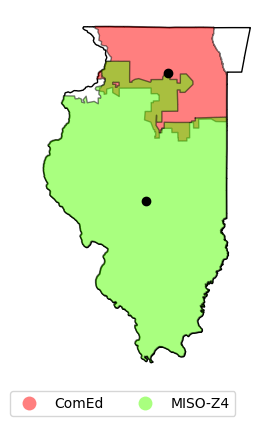

In [10]:
fig, ax = plt.subplots()
il_counties.dissolve('STATEFP10').plot(ax=ax,facecolor='w',edgecolor='k')
il_service_simple.plot(ax=ax, 
                column='CNTRL_AREA',
                categorical=True,
                cmap='prism',
                legend=True,
                legend_kwds=dict(loc=(-0.1, -0.1), ncols=3),
                alpha=0.5,
                edgecolor='k')
il_service_simple.centroids.plot(ax=ax, color='k')
ax.set_axis_off()

## Retrieve Solar Energy Data

In [11]:
il_service_simple.loc['MISO-Z4','AVG_GHI']

nan

In [12]:
save_dir = Path("../data/nrel_psm_data").resolve()
save_dir.mkdir(exist_ok=True)

In [13]:
personal_data = {'api_key':nrel_api_key,
                 'name':'Lee+Shaver',
                 'reason':'Research',
                 'affiliation':'Union+of+Concerned+Scientists',
                 'email':'lshaver@ucsusa.org',
                 'mailing_list':'false'}

In [14]:
pbar = tqdm(il_service_simple[['CNTRL_AREA', 'latitude_ctr','longitude_ctr']].loc[['ComEd','MISO-Z4']].values, position=0, leave=True)
for n, i, j in pbar:
    pbar.set_description(f"Processing {n}")
    parameters['lon'] = j
    parameters['lat'] = i
    URL = make_csv_url(parameters=parameters, personal_data=personal_data, kind='solar')
    df = pd.read_csv(URL, skiprows=2)
    avg_ghi = df.GHI.mean()
    il_service_simple.loc[n, 'AVG_GHI'] = avg_ghi
    y = parameters['year']
    data_path = save_dir/f'{n}_solar_{y}.csv'
    df[['GHI']].to_csv(data_path, index=False)

Processing ComEd:   0%|          | 0/2 [00:00<?, ?it/s]

Processing MISO-Z4: 100%|██████████| 2/2 [00:10<00:00,  5.49s/it]


## Retrieve Wind Speed Data

In [15]:
wind_attr = ['windspeed_80m','windspeed_100m']
parameters['attr_list'] = wind_attr
parameters['year'] = 2013
parameters

{'lon': -89.28055235574193,
 'lat': 39.62544491725518,
 'year': 2013,
 'leap_day': 'true',
 'selector': 'POINT',
 'utc': 'false',
 'interval': '60',
 'attr_list': ['windspeed_80m', 'windspeed_100m']}

In [16]:
il_service_simple['AVG_WIND_80M'] = np.nan

In [17]:
save_dir = Path("../data/nrel_wtk_data")
save_dir.mkdir(exist_ok=True)

In [18]:
pbar = tqdm(il_service_simple[['CNTRL_AREA', 'latitude_ctr','longitude_ctr']].loc[['ComEd','MISO-Z4']].values, position=0, leave=True)
for n, i, j in pbar:
    pbar.set_description(f"Processing {n}")
    parameters['lon'] = j
    parameters['lat'] = i
    URL = make_csv_url(parameters=parameters, personal_data=personal_data, kind='wind')
    df = pd.read_csv(URL, skiprows=1)
    avg_wind = df['wind speed at 80m (m/s)'].mean()
    il_service_simple.loc[n,'AVG_WIND_80M'] = avg_wind
    y = parameters['year']
    data_path = save_dir/f'{n}_wind_{y}.csv'
    df.rename(columns={"wind speed at 80m (m/s)":"wind_speed_80m", "wind speed at 100m (m/s)":"wind_speed_100m"}, inplace=True)
    df[['wind_speed_80m','wind_speed_100m']].to_csv(data_path, index=False)

Processing MISO-Z4: 100%|██████████| 2/2 [00:16<00:00,  8.26s/it]


# Map the data

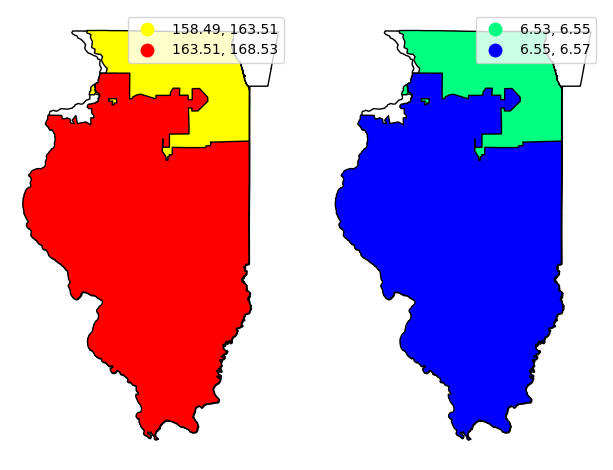

In [19]:
k = len(il_service_simple)
fig, ax = plt.subplots(1,2)
il_counties.dissolve('STATEFP10').plot(ax=ax[0],facecolor='w',edgecolor='k')
il_counties.dissolve('STATEFP10').plot(ax=ax[1],facecolor='w',edgecolor='k')
il_service_simple.plot(ax=ax[0], 
                column='AVG_GHI',
                scheme='equal_interval',
                k=k,
                cmap='autumn_r',
                legend=True,
                # alpha=0.5,
                edgecolor='k')
il_service_simple.plot(ax=ax[1], 
                column='AVG_WIND_80M',
                cmap='winter_r',
                scheme='equal_interval',
                k=k,
                legend=True,
                # alpha=0.5,
                edgecolor='k')
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()